<a href="https://colab.research.google.com/github/Devanshu0502/Sales-Prediction/blob/main/sales_Prediction_using_Essembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import norm, skew

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train=pd.read_csv('/content/drive/MyDrive/Projects/Big Mart Sales Prediction/Train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Projects/Big Mart Sales Prediction/Test.csv')

In [4]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df_train.isna().any()

Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<Axes: >

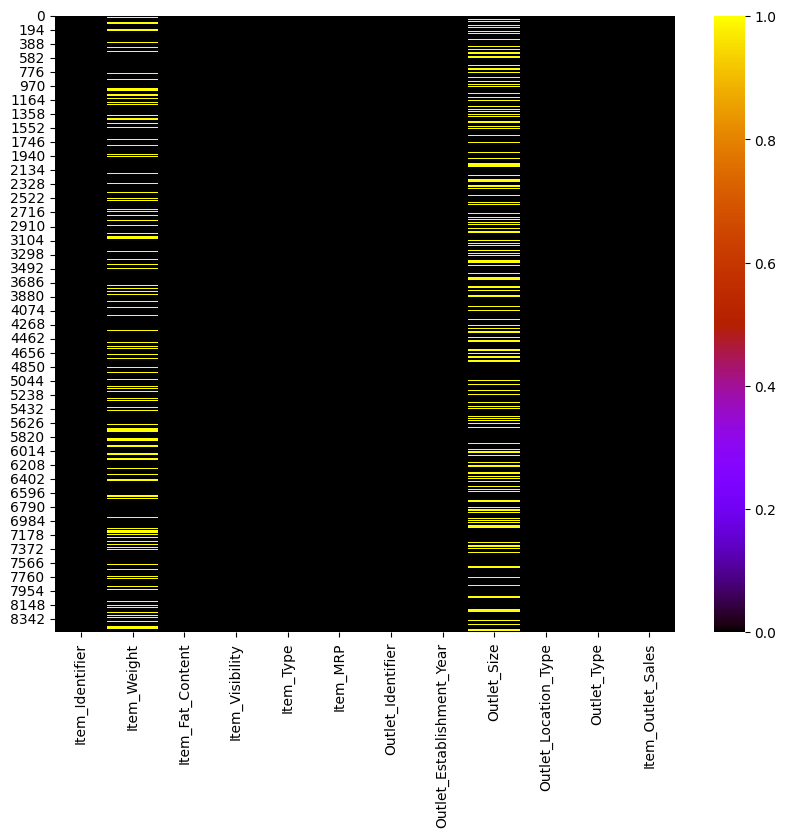

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train.isna(),cmap='gnuplot')

In [8]:
df_train['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

<ipython-input-9-d3651da6247b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['Item_Weight'].dropna(),color='green')


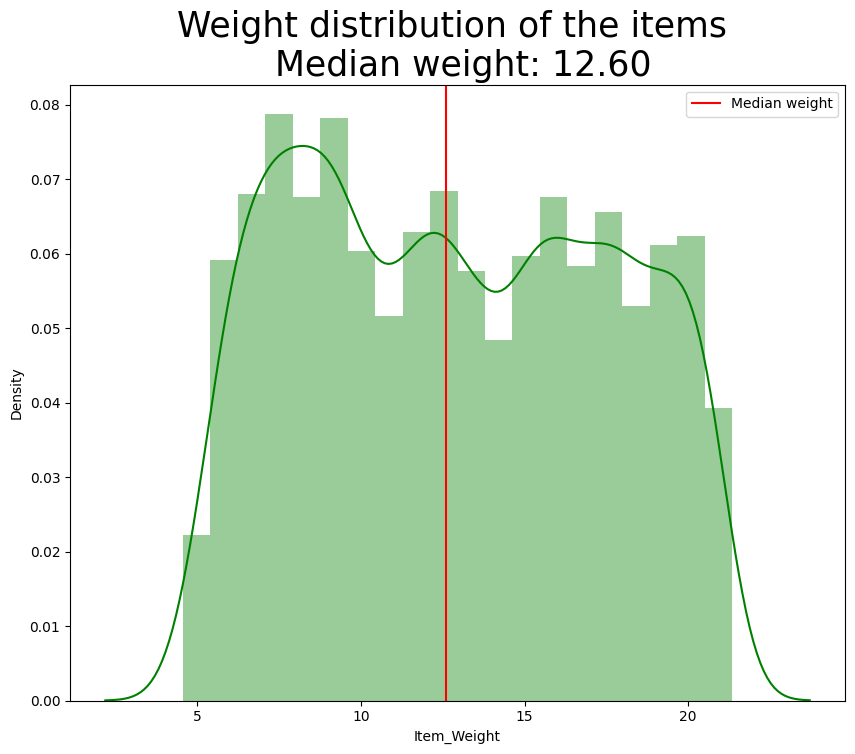

In [9]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Weight'].dropna(),color='green')
plt.title('Weight distribution of the items \n Median weight: {0:.2f}'.format(df_train['Item_Weight'].dropna().median()),size=25)
plt.axvline(df_train['Item_Weight'].dropna().median(),color='red',label='Median weight')
plt.legend()

Text(0.5, 1.0, 'Violinplot of weights')

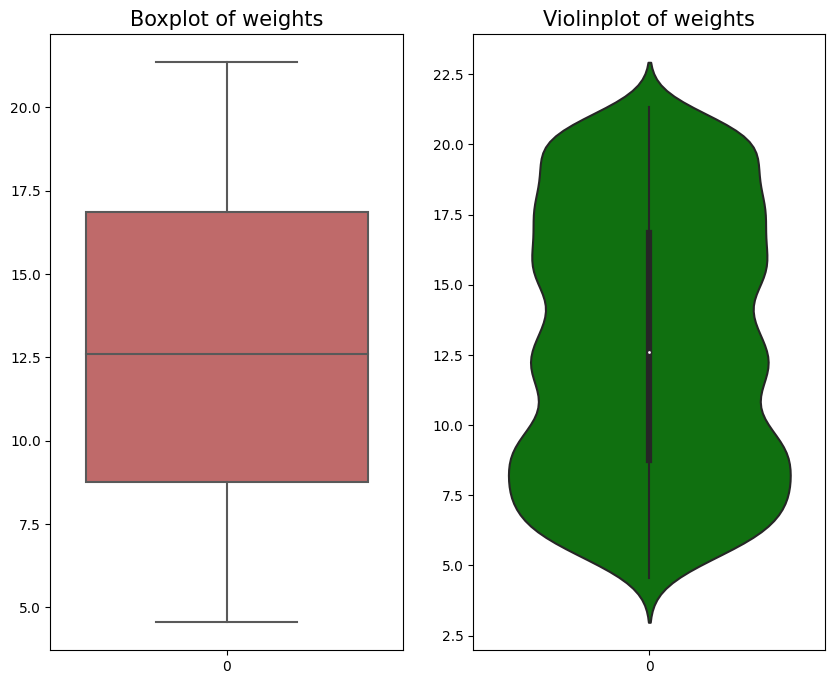

In [10]:
fig1=plt.figure(figsize=(10,8))
ax1=fig1.add_subplot(121)
sns.boxplot(df_train['Item_Weight'],ax=ax1,orient='v',color='indianred')
ax1.set_title('Boxplot of weights',size=15)

ax2=fig1.add_subplot(122)
sns.violinplot(df_train['Item_Weight'],ax=ax2,orient='v',color='green')
ax2.set_title('Violinplot of weights',size=15)

In [11]:
df_train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [12]:
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('low fat','Low Fat')
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('LF','Low Fat')
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('reg','Regular')
df_train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [13]:
df_train['Count']=1
df_fat=df_train.groupby('Item_Fat_Content')['Count'].sum().reset_index()

fig2=px.pie(df_fat,values='Count',names='Item_Fat_Content',hole=0.4)

fig2.update_layout(title='Fat content',title_x=0.48,
                  annotations=[dict(text='Fat',font_size=15, showarrow=False,height=800,width=900)])
fig2.update_traces(textfont_size=15,textinfo='percent+label')
fig2.show()

In [14]:
df_train['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

<ipython-input-15-c37e5cad5ad2>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




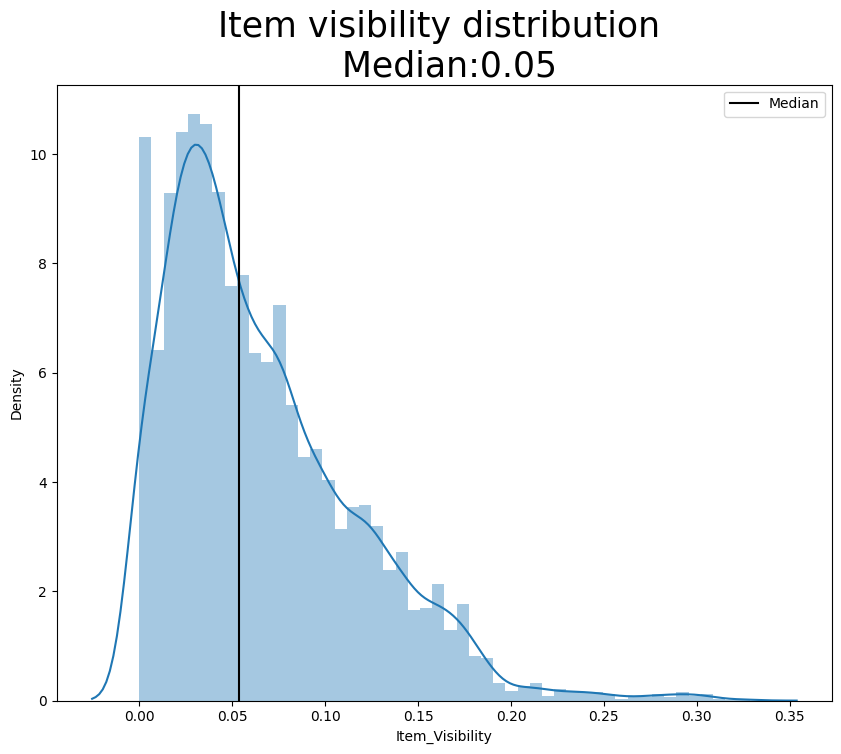

In [15]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Visibility'])
plt.title('Item visibility distribution \n Median:{0:.2f}'.format(df_train['Item_Visibility'].median()),size=25)
plt.axvline(df_train['Item_Visibility'].median(),color='black',label='Median')
plt.legend()

((array([-3.77092014, -3.54353752, -3.4185981 , ...,  3.4185981 ,
          3.54353752,  3.77092014]),
  array([0.        , 0.        , 0.        , ..., 0.32111501, 0.32578081,
         0.32839095])),
 (0.049348775274015065, 0.06613202877895107, 0.9560728731678176))

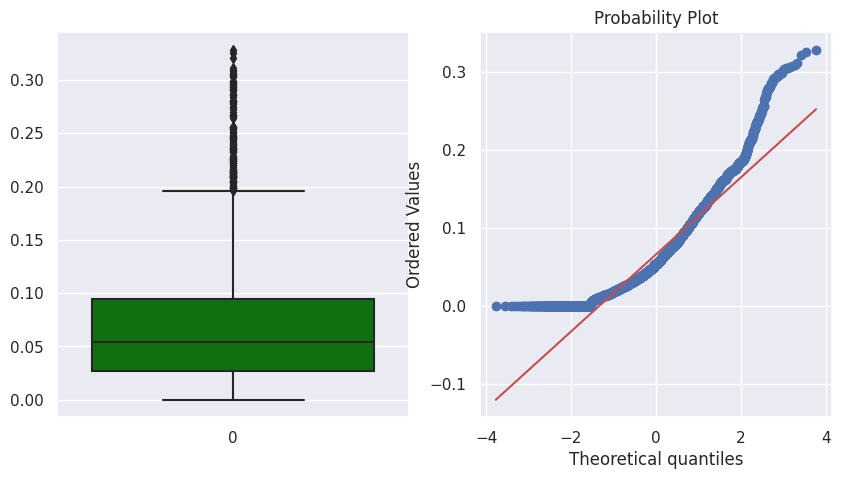

In [16]:
sns.set()
fig3=plt.figure(figsize=(10,5))
ax1=fig3.add_subplot(121)
sns.boxplot(df_train['Item_Visibility'],orient='v',ax=ax1,color='green')
ax2=fig3.add_subplot(122)
stats.probplot(df_train['Item_Visibility'],plot=ax2)

In [17]:
df_train[df_train['Item_Visibility']>0.2].shape[0]

134

((array([-3.7669643 , -3.53935697, -3.41428343, ...,  3.41428343,
          3.53935697,  3.7669643 ]),
  array([0.        , 0.        , 0.        , ..., 0.19899855, 0.19993588,
         0.19995527])),
 (0.044876265916263904, 0.06322235269591131, 0.9681235088881057))

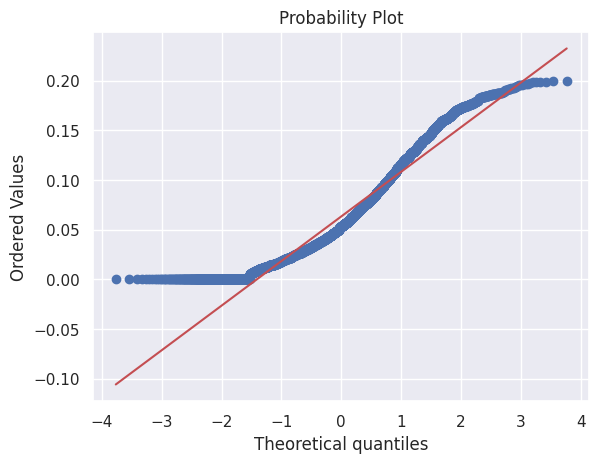

In [18]:
df_train=df_train[df_train['Item_Visibility']<0.2]
stats.probplot(df_train['Item_Visibility'],plot=plt)

<ipython-input-19-b2d198e98161>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




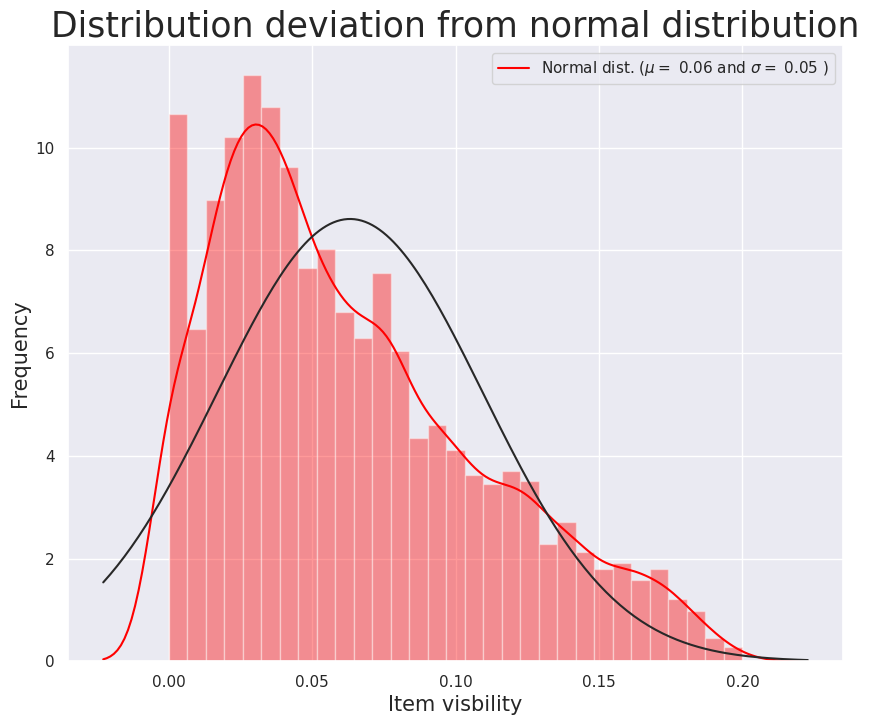

In [19]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Visibility'],fit=norm,color='red')
plt.title('Distribution deviation from normal distribution',size=25)
plt.ylabel('Frequency',size=15)
plt.xlabel('Item visbility',size=15)
mu=df_train['Item_Visibility'].mean()
sigma=df_train['Item_Visibility'].std()
plt.legend(['Normal dist. ($\mu=$ {0:.2f} and $\sigma=$ {1:.2f} )'.format(mu, sigma)])

In [20]:
df_type=df_train.groupby('Item_Type')['Count'].sum().reset_index()
fig4=px.sunburst(df_train,path=['Item_Type','Item_Fat_Content'],names='Item_Type',color_continuous_scale='RdBu')
fig4.update_layout(title='Item types',title_x=0.2,title_y=0.8,
                  annotations=[dict(showarrow=True,height=1000,width=900)],margin=dict(l=20, r=20, t=20, b=20))
fig4.show()

fig5=px.pie(df_type,values='Count',names='Item_Type')
fig5.update_layout(title='Item distribution',title_x=0.1,title_y=0.8)
fig5.update_traces(textfont_size=15,textinfo='percent')
fig5.show()

<ipython-input-21-85bbae259252>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




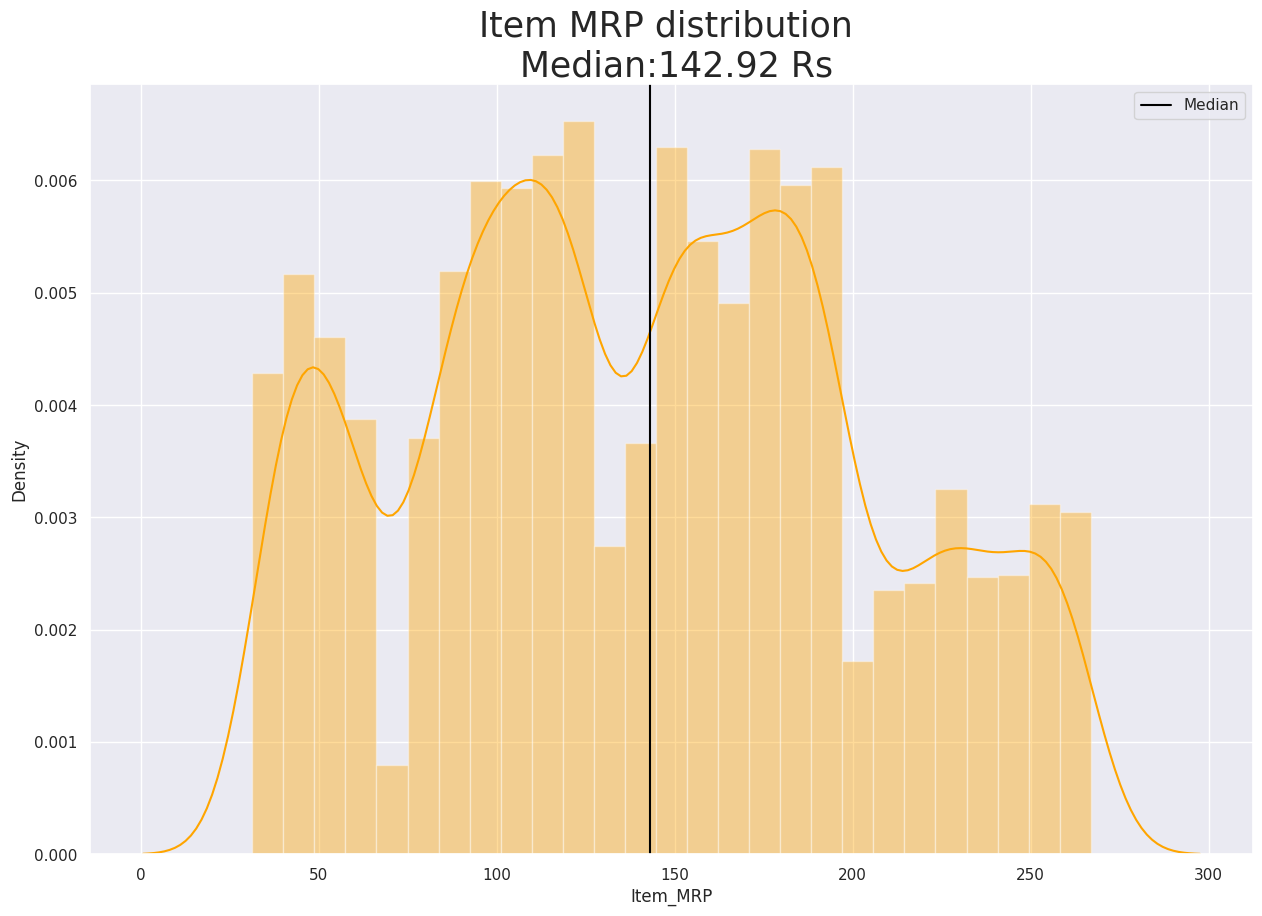

In [21]:
plt.figure(figsize=(15,10))
sns.distplot(df_train['Item_MRP'],color='orange')
plt.title('Item MRP distribution \n Median:{0:.2f} Rs'.format(df_train['Item_MRP'].median()),size=25)
plt.axvline(df_train['Item_MRP'].median(),color='black',label='Median')
plt.legend()

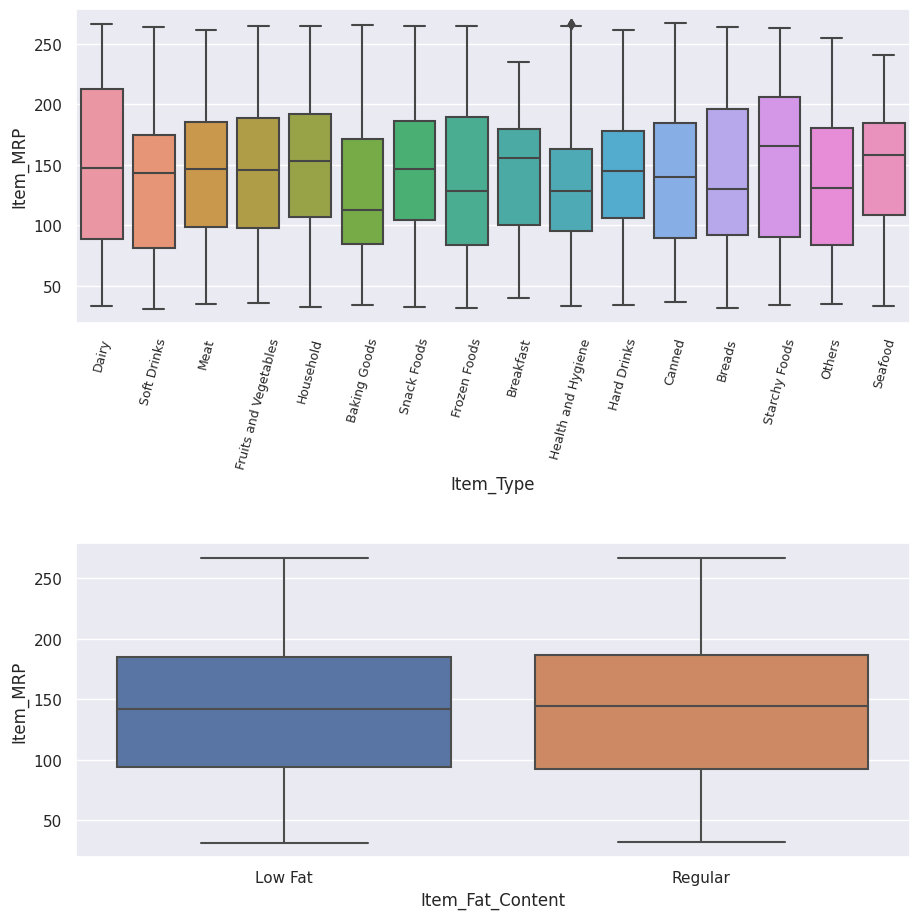

In [22]:
labels=df_train['Item_Type'].unique()
fig6=plt.figure(figsize=(10,10))
ax1=fig6.add_subplot(211)
sns.boxplot(x='Item_Type',y='Item_MRP',data=df_train,ax=ax1)
ax1.set_xticklabels(labels, rotation=75,size=9)

ax2=fig6.add_subplot(212)
sns.boxplot(x='Item_Fat_Content',y='Item_MRP',data=df_train,ax=ax2)

fig6.tight_layout(pad=3) #For spacing between subplots

In [23]:
df_outlets=df_train.groupby('Outlet_Identifier')['Count'].sum().reset_index().sort_values(by='Count',ascending=False)

([<matplotlib.axis.YTick at 0x7f3b45af3a90>,
 [Text(0, 0, '0'),
  Text(0, 100, '100'),
  Text(0, 200, '200'),
  Text(0, 300, '300'),
  Text(0, 400, '400'),
  Text(0, 500, '500'),
  Text(0, 600, '600'),
  Text(0, 700, '700'),
  Text(0, 800, '800'),
  Text(0, 900, '900'),
  Text(0, 1000, '1000')])

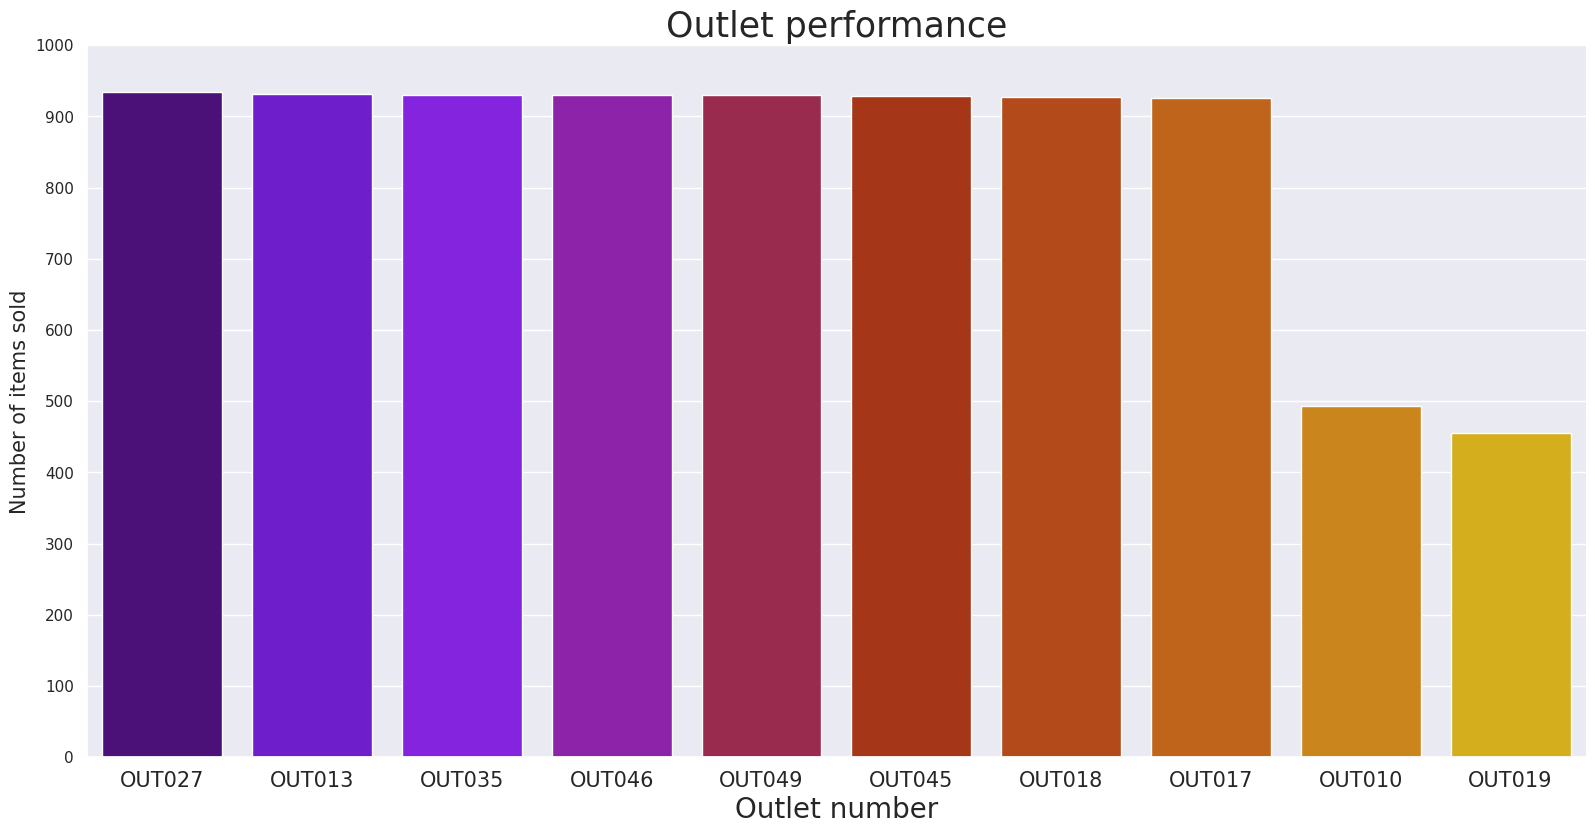

In [24]:
sns.catplot(x = 'Outlet_Identifier',y = 'Count',data=df_outlets,aspect=2,height=8,kind='bar',palette='gnuplot')
plt.xticks(size=15)
plt.ylabel('Number of items sold',size=15)
plt.xlabel('Outlet number',size=20)
plt.title('Outlet performance',size=25)
plt.yticks(np.arange(0,1100,100))

<Axes: xlabel='Outlet_Establishment_Year', ylabel='Item_MRP'>

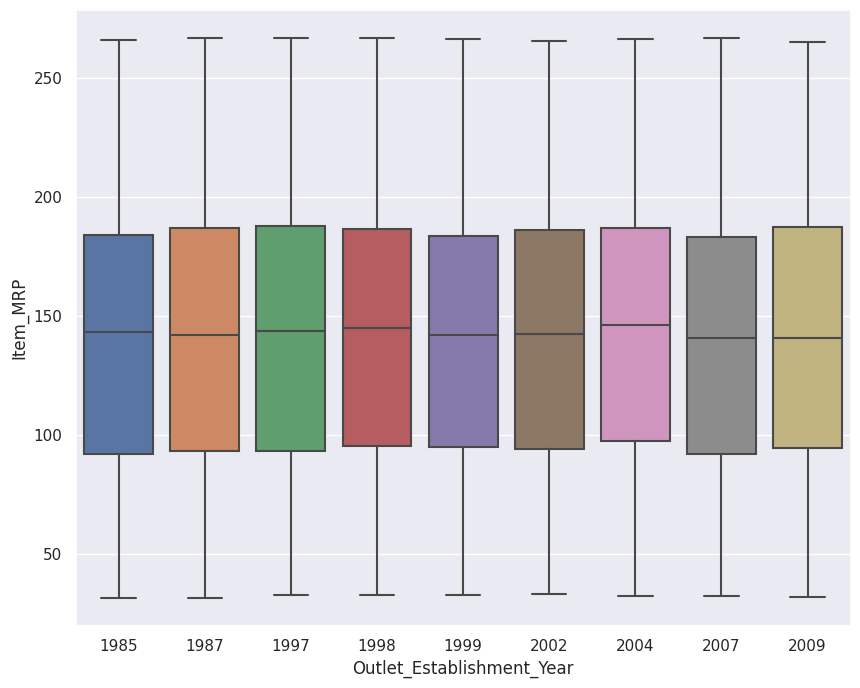

In [25]:
plt.figure(figsize=(10,8))
sns.boxplot(x = 'Outlet_Establishment_Year',y = 'Item_MRP',data=df_train)

Text(0.5, 1.0, 'Outlet sales')

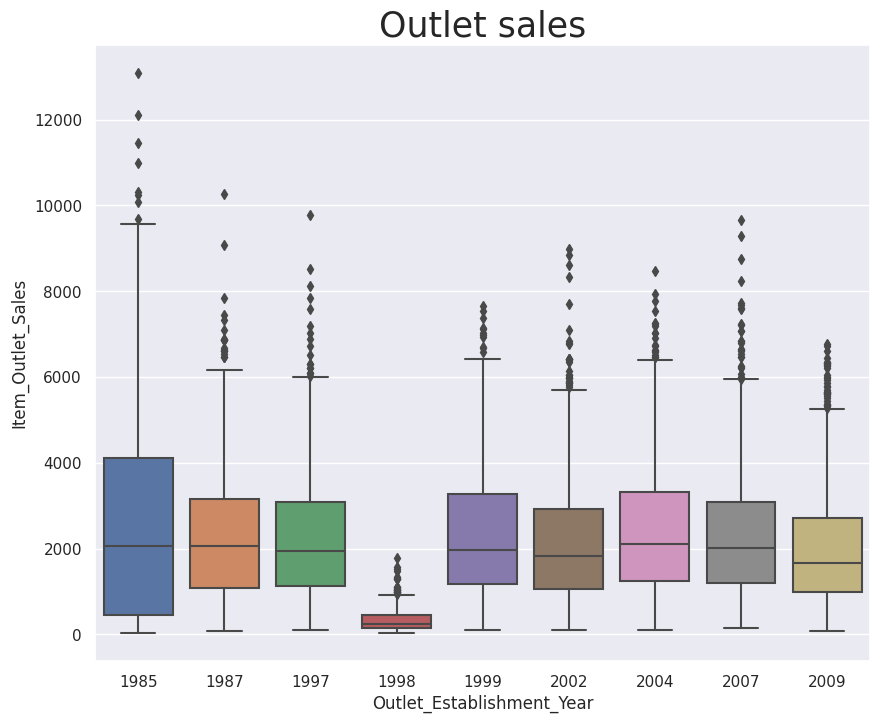

In [26]:
plt.figure(figsize=(10,8))
sns.boxplot(x = 'Outlet_Establishment_Year',y = 'Item_Outlet_Sales',data=df_train)
plt.title('Outlet sales',size=25)

In [27]:
df_train['Outlet_Size'].isna().value_counts()

False    6041
True     2348
Name: Outlet_Size, dtype: int64

In [28]:
df_size=df_train.groupby('Outlet_Size')['Count'].sum().reset_index()
fig7=px.pie(df_size,values='Count',names='Outlet_Size',hole=0.4)
fig7.update_layout(title='Store sizes',title_x=0.5,annotations=[dict(text='Fat',font_size=15, showarrow=False,height=800,width=900)])
fig7.update_traces(textfont_size=15,textinfo='percent+label')
fig7.show()

In [29]:
df_size_sales=df_train.groupby('Outlet_Size')[['Item_MRP','Item_Outlet_Sales']].mean().reset_index()

In [30]:
df_size_sales

,Outlet_Size,Item_MRP,Item_Outlet_Sales
0,High,141.425982,2298.995256
1,Medium,140.590514,2681.603542
2,Small,141.756737,1960.412740


Text(0.5, 1.0, 'Average sales of store')

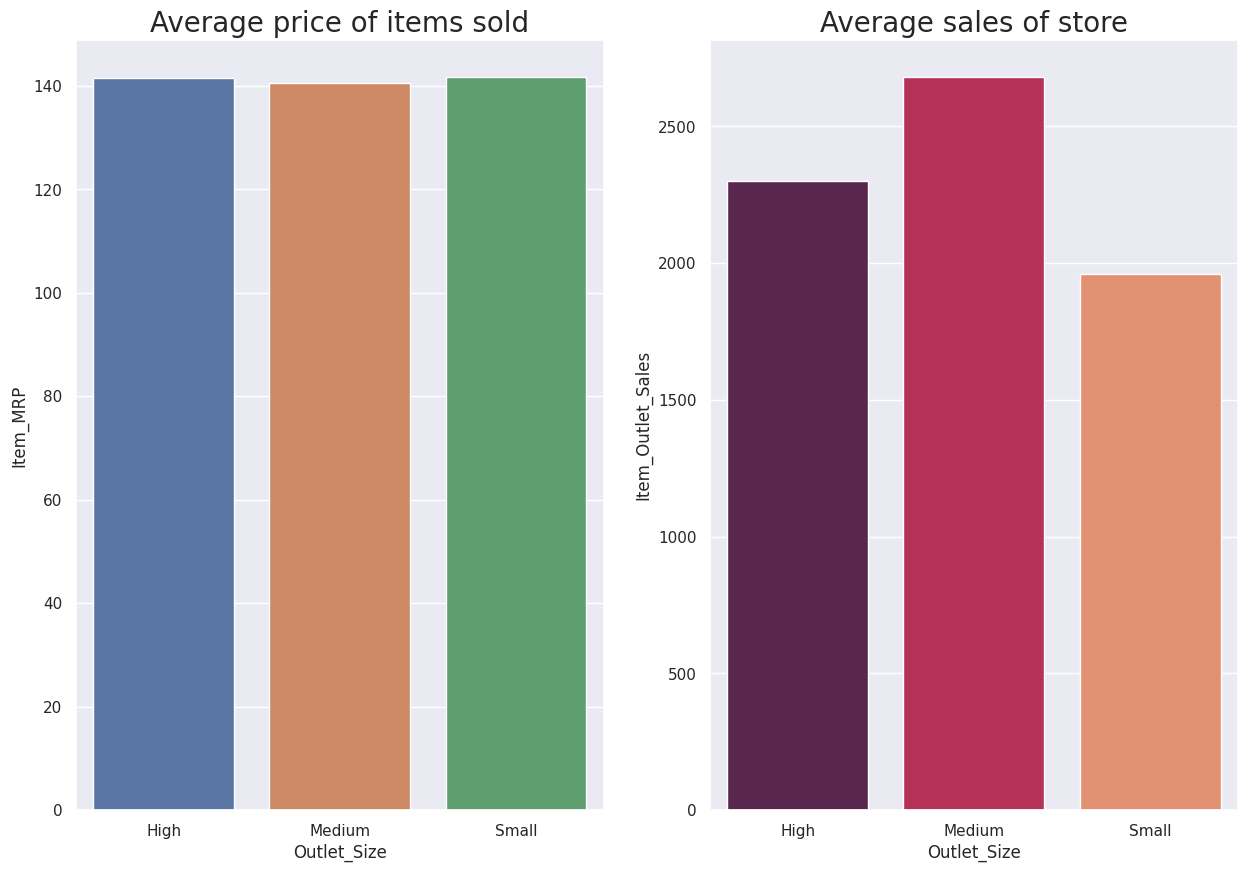

In [31]:
fig8=plt.figure(figsize=(15,10))
ax1=fig8.add_subplot(121)
sns.barplot(x = 'Outlet_Size',y ='Item_MRP',data=df_size_sales,ax=ax1)

ax2=fig8.add_subplot(122)
sns.barplot(x = 'Outlet_Size',y = 'Item_Outlet_Sales',data=df_size_sales,ax=ax2,palette='rocket')

ax1.set_title('Average price of items sold',size=20)
ax2.set_title('Average sales of store',size=20)

In [32]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Count
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,1
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,1
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,1
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,1
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,1


In [33]:
fig9=px.sunburst(df_train,path=['Outlet_Type','Outlet_Location_Type'],color_continuous_scale='RdBu')
fig9.update_layout(title='Store type with location type',title_x=0.5)
fig9.show()

<Axes: xlabel='Outlet_Location_Type', ylabel='Item_Outlet_Sales'>

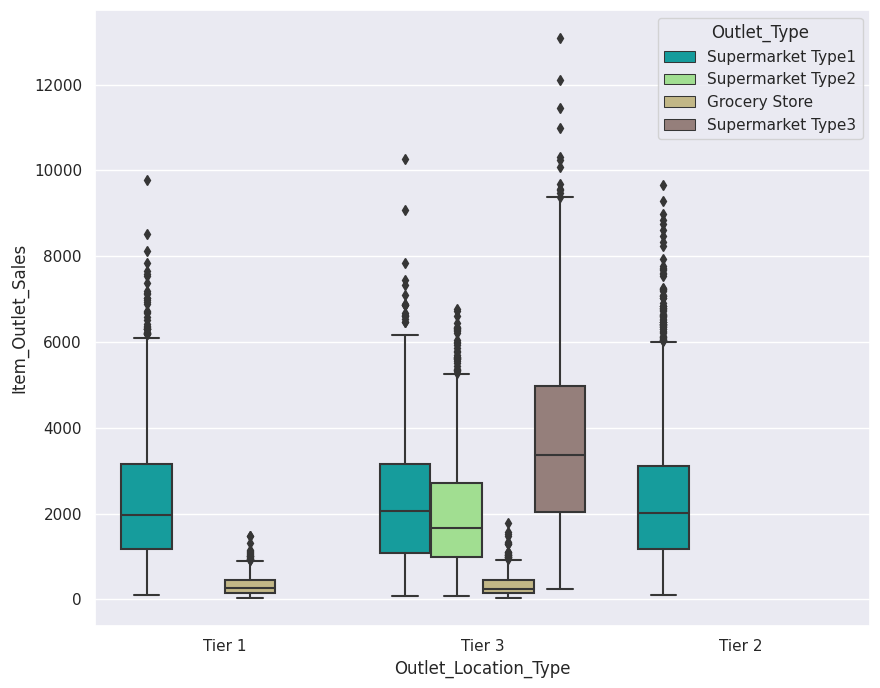

In [34]:
plt.figure(figsize=(10,8))
sns.boxplot(y='Item_Outlet_Sales',hue='Outlet_Type',x='Outlet_Location_Type',data=df_train,palette='terrain')

In [35]:
df_train.drop('Count',axis=1,inplace=True)

<Axes: >

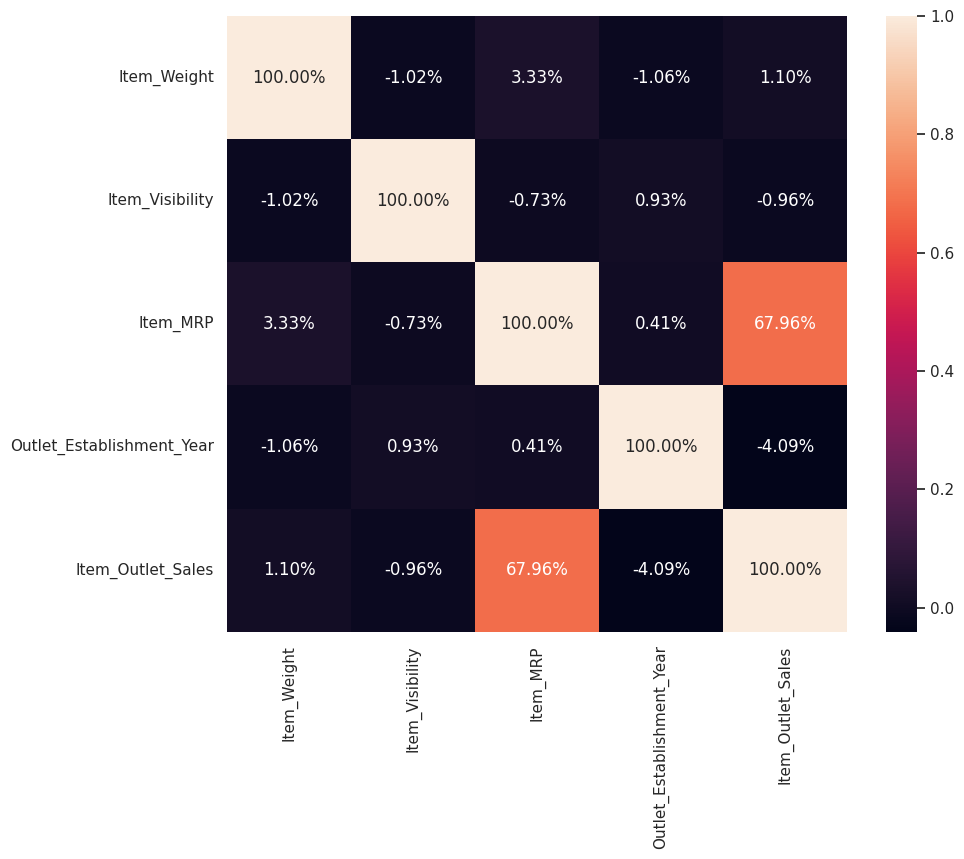

In [36]:
corrs=df_train.dropna().corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrs,annot=True,fmt='.2%')

In [37]:
unn_cols=['Item_Weight','Outlet_Size','Item_Identifier','Outlet_Identifier']

for cols in unn_cols:
    df_train.drop(cols,axis=1,inplace=True)

In [38]:
df_train['Item_Fat_Content'].replace('Low Fat',1,inplace=True)
df_train['Item_Fat_Content'].replace('Regular',0,inplace=True)

In [39]:
df_dummies_type=pd.get_dummies(df_train['Item_Type'])

In [40]:
df_train=df_train.merge(df_dummies_type,on=df_train.index)

In [41]:
df_train.drop('key_0',axis=1,inplace=True)
df_train.drop('Item_Type',axis=1,inplace=True)

In [42]:
df_train['Outlet_Location_Type'].replace('Tier 1',1,inplace=True)
df_train['Outlet_Location_Type'].replace('Tier 2',2,inplace=True)
df_train['Outlet_Location_Type'].replace('Tier 3',3,inplace=True)

In [43]:
df_dummies_outlet=pd.get_dummies(df_train['Outlet_Type'])
df_train=df_train.merge(df_dummies_outlet,on=df_train.index)

In [44]:
df_train.drop('key_0',axis=1,inplace=True)
df_train.drop('Outlet_Type',axis=1,inplace=True)

In [45]:
targets=df_train['Item_Outlet_Sales']
df_train.drop('Item_Outlet_Sales',axis=1,inplace=True)
df_train.head()

,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Location_Type,Baking Goods,Breads,Breakfast,Canned,Dairy,...,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,1,0.016047,249.8092,1999,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0.019278,48.2692,2009,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0.016760,141.6180,1999,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0.000000,182.0950,1998,3,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0.000000,53.8614,1987,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
X_train,X_test,y_train,y_test=train_test_split(df_train,targets,shuffle=True,test_size=0.2,random_state=0)

In [47]:
reg_lin=LinearRegression()
reg_lin.fit(X_train,y_train)

LinearRegression()

In [48]:
reg_lin.score(X_train,y_train)

0.5620345988855906

In [49]:
y_preds_lin=reg_lin.predict(X_test)
rmse_lin=np.sqrt(mean_squared_error(y_preds_lin,y_test))
print('RMSE for Linear Regression:{0:.2f}'.format(rmse_lin))

RMSE for Linear Regression:1130.81


Text(0.5, 1.0, 'Linear Regression \n RMSE: 1130.81')

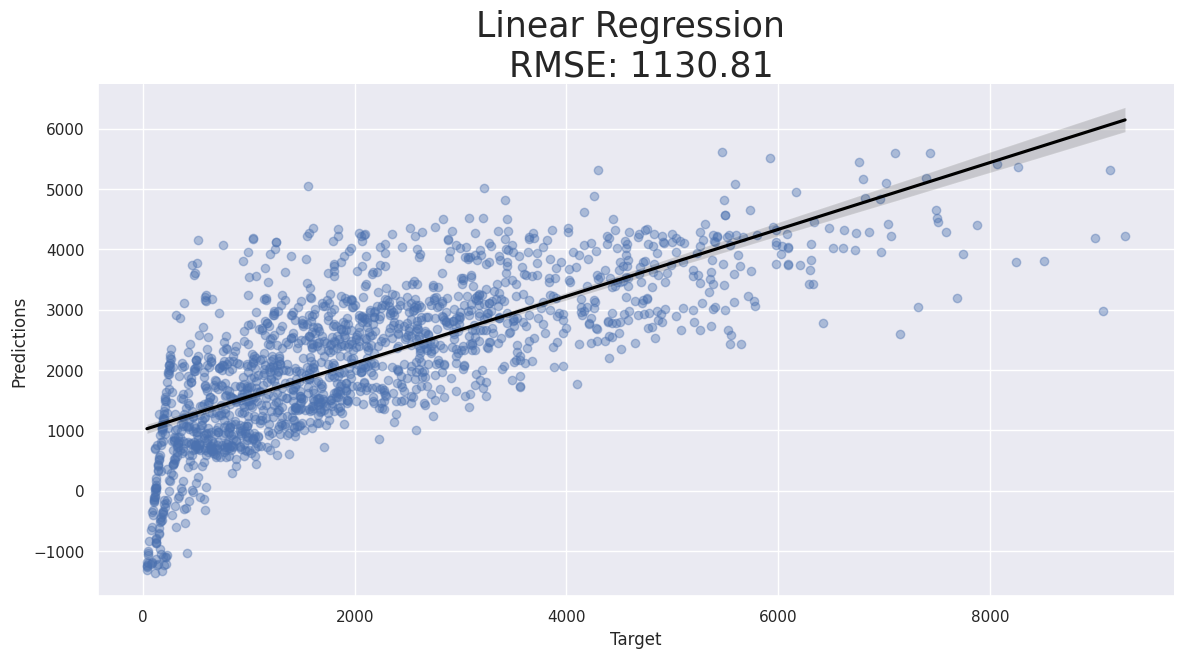

In [50]:
reg_lin_df=pd.DataFrame()
reg_lin_df['Target']=y_test
reg_lin_df['Predictions']=y_preds_lin

sns.lmplot(x='Target',y='Predictions',data=reg_lin_df,height=6,aspect=2,line_kws={'color':'black'},scatter_kws={'alpha':0.4})
plt.title('Linear Regression \n RMSE: {0:.2f}'.format(rmse_lin),size=25)

In [51]:
reg_rid=RidgeCV(cv=10)
reg_rid.fit(X_train,y_train)

RidgeCV(cv=10)

In [52]:
reg_rid.score(X_train,y_train)

0.5619667255114942

In [53]:
y_preds_rid=reg_rid.predict(X_test)
rmse_rid=np.sqrt(mean_squared_error(y_preds_rid,y_test))
print('RMSE for Ridge Regression:{0:.2f}'.format(rmse_rid))

RMSE for Ridge Regression:1130.70


Text(0.5, 1.0, 'Ridge Regression \n RMSE: 1130.70')

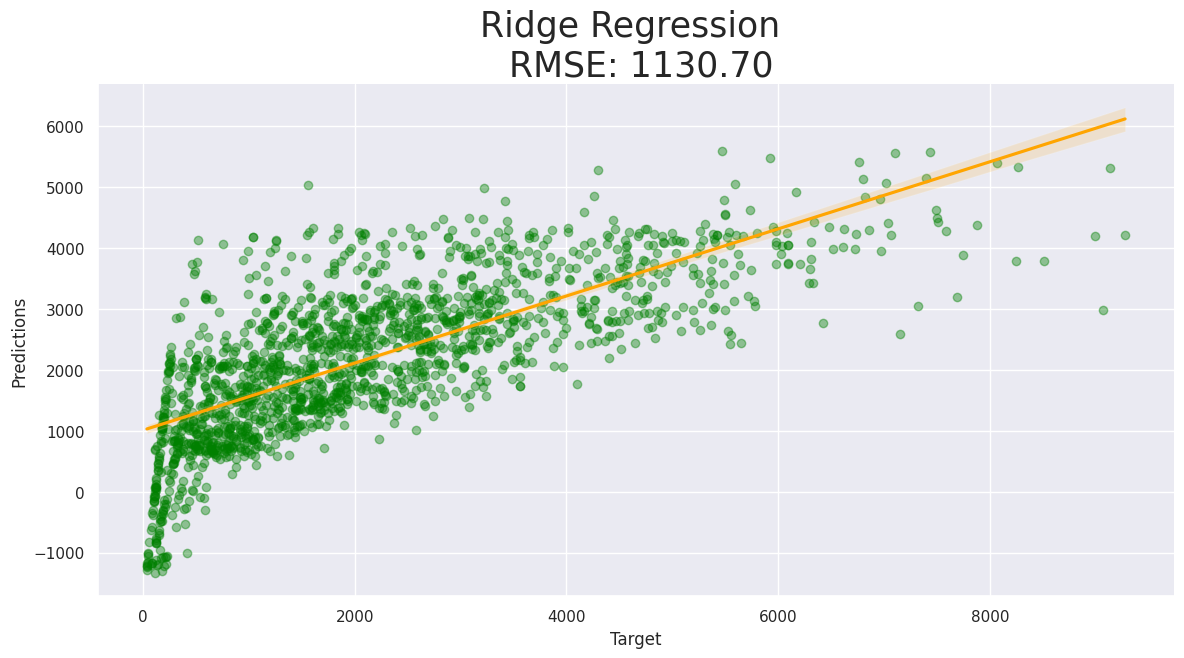

In [54]:
reg_rid_df=pd.DataFrame()
reg_rid_df['Target']=y_test
reg_rid_df['Predictions']=y_preds_rid

sns.lmplot(x='Target',y='Predictions',data=reg_rid_df,height=6,aspect=2,line_kws={'color':'orange'},scatter_kws={'alpha':0.4,'color':'green'})
plt.title('Ridge Regression \n RMSE: {0:.2f}'.format(rmse_rid),size=25)

In [55]:
reg_las=Lasso()
reg_las.fit(X_train,y_train)
reg_las.score(X_train,y_train)

0.5617750843494751

In [56]:
y_preds_las=reg_las.predict(X_test)
rmse_las=np.sqrt(mean_squared_error(y_preds_las,y_test))
print('RMSE for Lasso Regression:{0:.2f}'.format(rmse_las))

RMSE for Lasso Regression:1128.80


Text(0.5, 1.0, 'Lasso Regression \n RMSE: 1128.80')

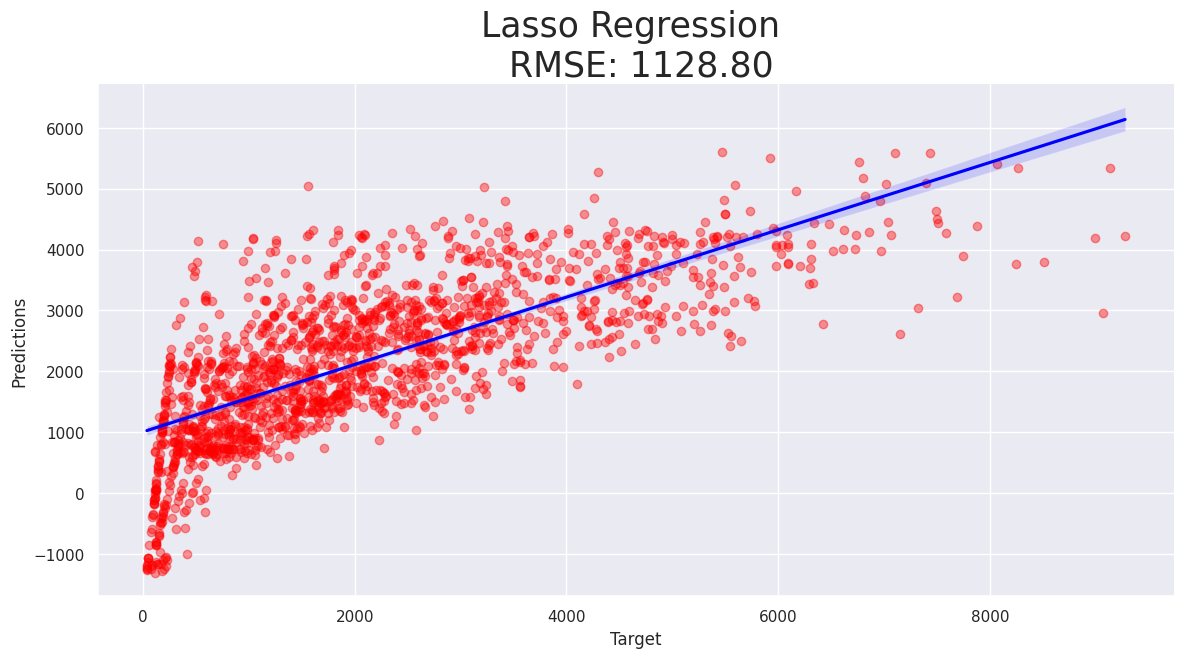

In [57]:
reg_las_df=pd.DataFrame()
reg_las_df['Target']=y_test
reg_las_df['Predictions']=y_preds_las

sns.lmplot(x='Target',y='Predictions',data=reg_las_df,height=6,aspect=2,line_kws={'color':'blue'},scatter_kws={'alpha':0.4,'color':'red'})
plt.title('Lasso Regression \n RMSE: {0:.2f}'.format(rmse_las),size=25)

In [58]:
rfr=RandomForestRegressor(random_state=0)
param_grid={'n_estimators':[3,4,5,7,9,10,12], 'max_depth':[5,7,9,10,12]}
grid=GridSearchCV(rfr,param_grid,scoring='r2',cv=10)

In [59]:
grid_result=grid.fit(X_train,y_train)
grid_result.best_params_

{'max_depth': 5, 'n_estimators': 10}

In [60]:
grid_result.score(X_train,y_train)

0.6037626015518893

In [61]:
y_preds_rfr=grid_result.predict(X_test)
rmse_rfr=np.sqrt(mean_squared_error(y_preds_rfr,y_test))
print('RMSE for Random Forest Regression:{0:.2f}'.format(rmse_rfr))

RMSE for Random Forest Regression:1077.74


Text(0.5, 1.0, 'Random Forest Regression \n RMSE: 1077.74')

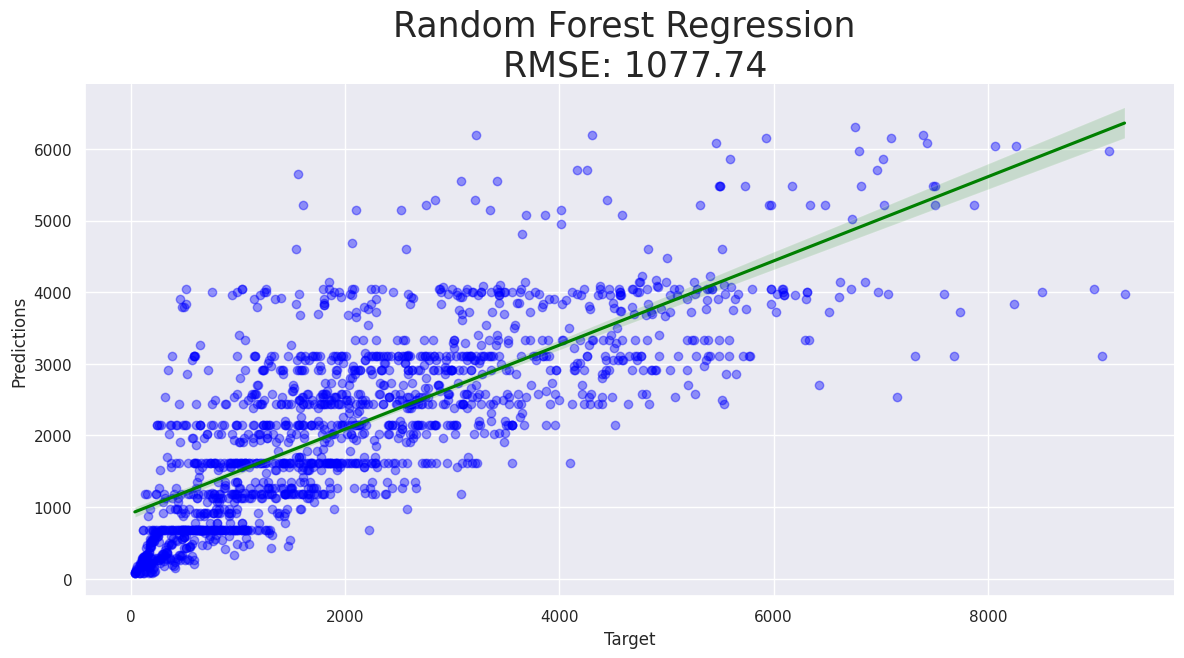

In [62]:
rfr_df=pd.DataFrame()
rfr_df['Target']=y_test
rfr_df['Predictions']=y_preds_rfr

sns.lmplot(x='Target',y='Predictions',data=rfr_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'blue'})
plt.title('Random Forest Regression \n RMSE: {0:.2f}'.format(rmse_rfr),size=25)

In [63]:
gbdt=GradientBoostingRegressor(random_state=0)
gbdt.fit(X_train,y_train)
gbdt.score(X_train,y_train)

0.6313952890813279

In [64]:
y_preds_gbdt=gbdt.predict(X_test)
rmse_gbdt=np.sqrt(mean_squared_error(y_preds_gbdt,y_test))
print('RMSE for Random Forest Regression:{0:.2f}'.format(rmse_gbdt))

RMSE for Random Forest Regression:1080.07


Text(0.5, 1.0, 'GBDT Regression \n RMSE: 1080.07')

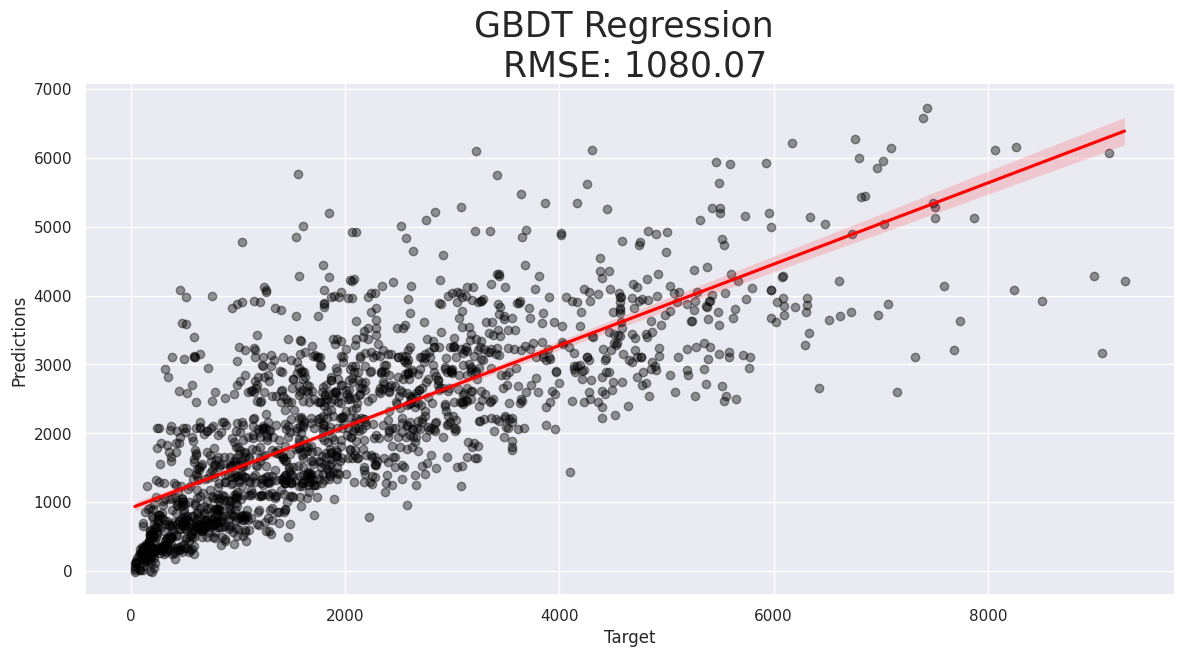

In [65]:
gbdt_df=pd.DataFrame()
gbdt_df['Target']=y_test
gbdt_df['Predictions']=y_preds_gbdt

sns.lmplot(x='Target',y='Predictions',data=gbdt_df,height=6,aspect=2,line_kws={'color':'red'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('GBDT Regression \n RMSE: {0:.2f}'.format(rmse_gbdt),size=25)

In [66]:
ada=AdaBoostRegressor(random_state=0)
ada.fit(X_train,y_train)

AdaBoostRegressor(random_state=0)

In [67]:
y_preds_ada=ada.predict(X_test)
rmse_ada=np.sqrt(mean_squared_error(y_preds_ada,y_test))
print('RMSE for AdaBoost Regression:{0:.2f}'.format(rmse_ada))

RMSE for AdaBoost Regression:1225.99


Text(0.5, 1.0, 'AdaBoost Regression \n RMSE: 1225.99')

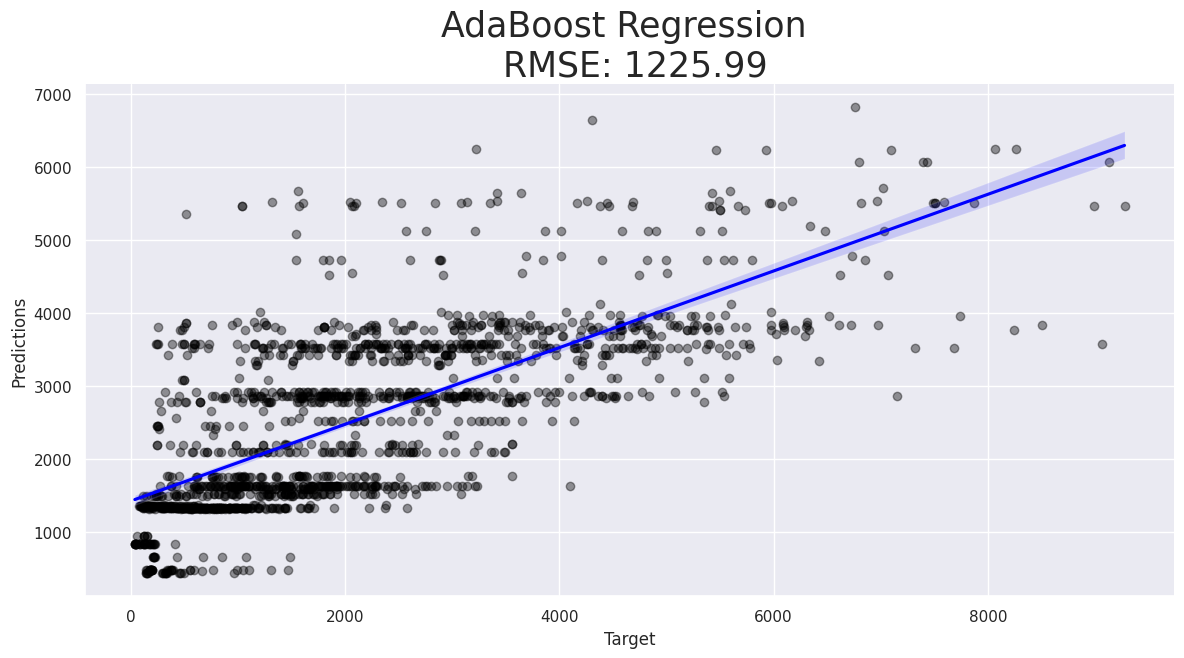

In [68]:
ada_df=pd.DataFrame()
ada_df['Target']=y_test
ada_df['Predictions']=y_preds_ada

sns.lmplot(x= 'Target',y= 'Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'blue'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('AdaBoost Regression \n RMSE: {0:.2f}'.format(rmse_ada),size=25)

In [69]:
xgb_reg=xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [70]:
xgb_reg.fit(X_train,y_train)
xgb_reg.score(X_train,y_train)

[12:02:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



0.73346276531733

In [71]:
y_preds_xgb=xgb_reg.predict(X_test)
rmse_xgb=np.sqrt(mean_squared_error(y_preds_xgb,y_test))
print('RMSE for XGBoost Regression:{0:.2f}'.format(rmse_xgb))

RMSE for XGBoost Regression:1121.91


Text(0.5, 1.0, 'XGBoost Regression \n RMSE: 1121.91')

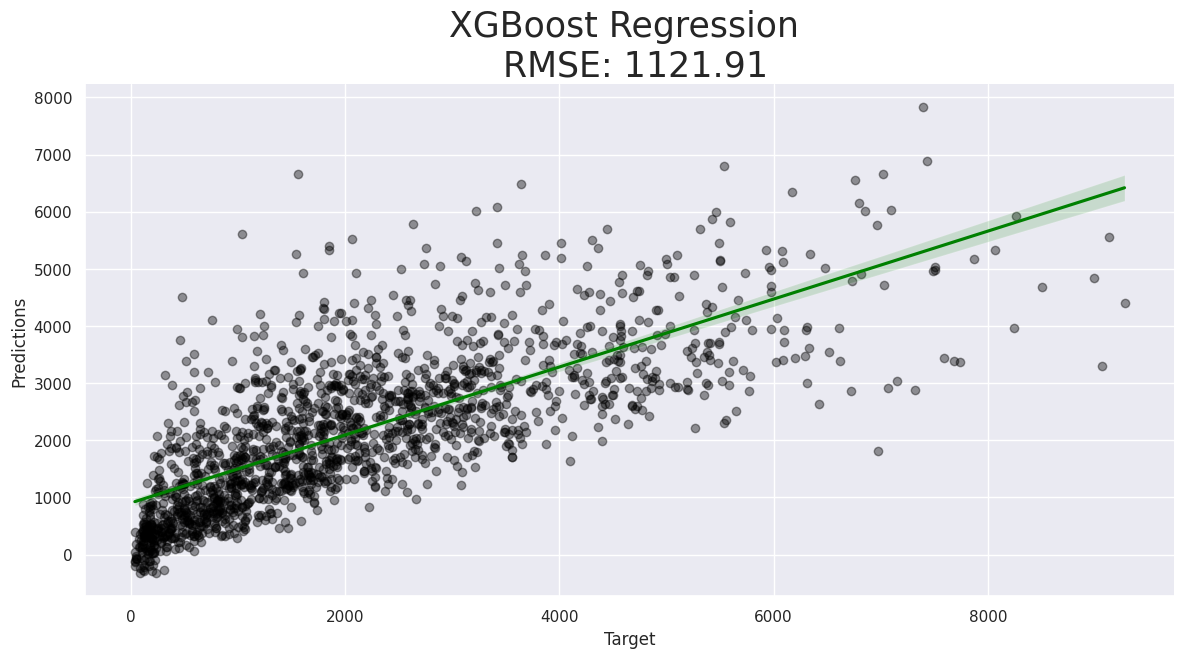

In [72]:
ada_df=pd.DataFrame()
ada_df['Target']=y_test
ada_df['Predictions']=y_preds_xgb

sns.lmplot(x= 'Target',y= 'Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('XGBoost Regression \n RMSE: {0:.2f}'.format(rmse_xgb),size=25)

In [73]:
lgb=LGBMRegressor(random_state=0)
lgb.fit(X_train,y_train)
lgb.score(X_train,y_train)

0.7069127746285484

In [74]:
y_preds_lgb=lgb.predict(X_test)
rmse_lgb=np.sqrt(mean_squared_error(y_preds_lgb,y_test))
print('RMSE for LGBM Regression:{0:.2f}'.format(rmse_lgb))

RMSE for LGBM Regression:1097.67


Text(0.5, 1.0, 'LGBM Regression \n RMSE: 1097.67')

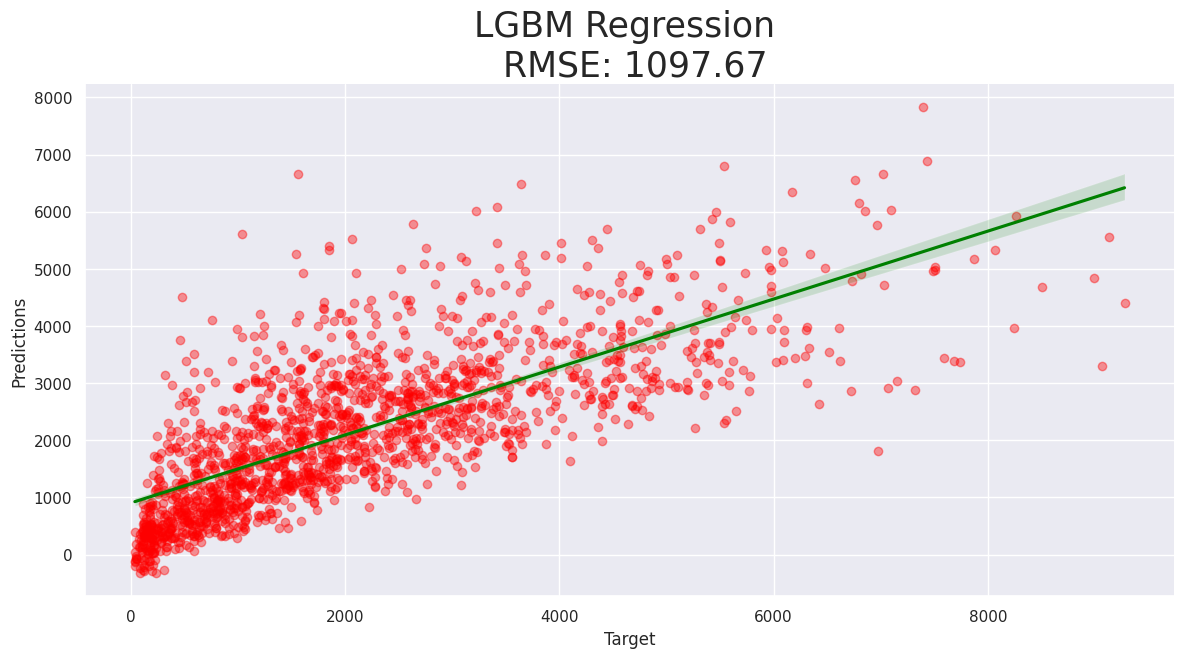

In [75]:
lgb_df=pd.DataFrame()
lgb_df['Target']=y_test
lgb_df['Predictions']=y_preds_lgb

sns.lmplot(x= 'Target',y = 'Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'red'})
plt.title('LGBM Regression \n RMSE: {0:.2f}'.format(rmse_lgb),size=25)